### TP 2 VISIÓN POR COMPUTADORA.

Integrantes: 
- Fernando Vasconcelos
- Lara Rosenberg
- Victoria TeránObjetivo:



# Objetivo
### Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib
import pandas as pd


In [2]:
# Ruta del video
video_path = 'video/focus_video.mov'

#### Definimos funciones auxiliares

In [4]:
def calcular_acm(image):
    mean = np.mean(image)
    histogram, _ = np.histogram(image, bins=256, range=(0, 256))
    histogram = histogram / histogram.sum()
    acm = np.sum(np.abs(np.arange(256) - mean) * histogram)
    return acm

In [20]:
class Roi:
    def __init__(self, frame_height: int, frame_width: int, roi: float = 1, height: int = 1, width: int = 1) -> None:
        if roi > 1 or roi <= 0:
            raise ValueError('roi is out of range')

        self.roi = roi
        self.frame_height = frame_height
        self.frame_width = frame_width

        if roi == 1:
            if height > frame_height or width > frame_width:
                raise ValueError('Height/width of the image must be less than the frame height/width')
            self.height = height
            self.width = width
        else:
            # Get height and width
            self.height = int(frame_height * self.roi)
            self.width = int(frame_width * self.roi)

        self.y_start = (frame_height - self.height) // 2
        self.x_start = (frame_width - self.width) // 2

    def apply(self, image: np.array) -> np.array:
        return image[self.y_start:self.y_start + self.height, self.x_start:self.x_start + self.width]

    def get_focus_matrix(self, nrows: int, ncols: int) -> np.array:
        overlay = np.zeros((self.frame_height, self.frame_width, 3), dtype=np.uint8)

        # Calcular el tamaño de cada rectángulo
        rect_width = self.width // (2 * ncols - 1)
        rect_height = self.height // (2 * nrows - 1)

        # Para que los rectangulos esten equidistantes calculamos el margen minimo y ajustamos el lado 
        if rect_width < rect_height:
            margin = rect_width
            rect_height = (self.height - margin * (nrows - 1)) // nrows
        else:
            margin = rect_height
            rect_width = (self.width - margin * (ncols - 1)) // ncols

        # Dibujar la matriz de rectángulos en la capa de superposición
        for i in range(nrows):
            for j in range(ncols):
                # Calcular las coordenadas del rectángulo
                x_start = self.x_start + j * (rect_width + margin)
                y_start = self.y_start + i * (rect_height + margin)

                x_end = x_start + rect_width
                y_end = y_start + rect_height
                # Dibujar los rectángulos en la capa de superposición (con color verde)
                cv2.rectangle(overlay, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)

        return overlay


In [81]:
class VideoPlayer:

    def __init__(self, file: str) -> None:
        self.video = cv2.VideoCapture(video_path)
        if not self.video.isOpened():
            raise IOError('Video\'s not opened')
        self._frame_height = int(self.video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self._frame_width = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH))
        self._frame_count = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
        self._fps = int(self.video.get(cv2.CAP_PROP_FPS))

        self._roi = None
        self._is_roi_set = False
        self._is_matrix_set = False
        self._matrix_row = 3
        self._matrix_col = 3
        self._current_frame = None

    def set_roi(self, roi: float = 1, height: int = 1, width: int = 1, matrix: bool = False, nrows: int = 3,
                ncols: int = 3) -> None:
        # If there was a roi, delete it
        self.unset_roi()
        self._roi = Roi(self._frame_height, self._frame_width, roi=roi, height=height, width=width)
        self._is_roi_set = True
        self._is_matrix_set = matrix
        self._matrix_row = nrows
        self._matrix_col = ncols

    def unset_roi(self):
        if self._is_roi_set and self._roi:
            del self._is_roi_set
            self._is_roi_set = False
            self._is_matrix_set = False

    @property
    def is_roi_set(self):
        return self._is_roi_set

    @property
    def shape(self):
        return self._frame_height, self._frame_width

    @property
    def fps(self):
        return self._fps

    @fps.setter
    def fps(self, value):
        self._fps = value

    @property
    def frame_count(self):
        return self._frame_count

    @frame_count.setter
    def frame_count(self, value):
        self._frame_count = value

    def get_frame(self) -> np.array:    
        ret, self._current_frame = self.video.read()
        if not ret:
            return None

        if self._is_matrix_set:
            focus_matrix = self._roi.get_focus_matrix(self._matrix_row, self._matrix_col)
            frame = cv2.bitwise_or(focus_matrix, self._current_frame)
            return frame

        return self._current_frame

    def get_frame_by_index(self, index: int) -> np.array:
        self.set_video_pos(index)
        return self.get_frame()

    def get_roi_frame(self) -> np.array:
        if not self._is_roi_set:
            return cv2.cvtColor(self._current_frame, cv2.COLOR_BGR2GRAY)
        return self._roi.apply(cv2.cvtColor(self._current_frame, cv2.COLOR_BGR2GRAY))

    def restart(self):
        self.video.set(cv2.CAP_PROP_POS_FRAMES, 0)

    def set_video_pos(self, frame_index):
        if frame_index < 1 or frame_index > self._frame_count:
            raise ValueError('Frame index out of range')
        self.video.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    def get_video_pos(self):
        return self.video.get(cv2.CAP_PROP_POS_FRAMES)

    def release(self):
        self.video.release()

In [6]:
def convert_to_img(value_list: list, image_shape: tuple, total_frames: int):
    fig, ax = plt.subplots(figsize=(image_shape[1] / 100, image_shape[0] / 100))
    ax.set_xlim(0, total_frames + total_frames * 0.1)
    ax.scatter(range(len(value_list)), value_list)
    ax.set_xlabel('Número de Frame', labelpad=1)
    ax.set_ylabel('IQM')
    ax.set_title('Evolución IQM por Frame', fontsize=10)
    ax.grid(True)

    # Convertir el gráfico en un array
    canvas = FigureCanvas(fig)
    canvas.draw()
    plt.close(fig)
    width, height = canvas.get_width_height()
    # Convertir a un array de NumPy 
    image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8').reshape((height, width, 4))

    # Remove alplha channel and return
    return image[:, :, :3]

In [100]:
def graficar(x, y, x_label="Numero de frame", y_label="Metrica"):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='brown', marker='o')
    # Etiquetas y título
    plt.xlabel(x_label)
    plt.ylabel(f'{y_label}')
    plt.title(f'Evolución {y_label} por Frame')
    max_value = max(y)
    max_index = x[y.index(max_value)]
    plt.scatter(max_index, max_value, color='red', label='Máximo valor')
    plt.annotate(f'Frame {max_index}\n Máx: {max_value}', xy=(max_index, max_value), xytext=(max_index + 10, max_value - 0.002),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.grid(True)
    plt.show()
    
def graficar_con_frame(x, y, x_label="Numero de frame", y_label="Metrica", frame_image=None):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, color='brown', marker='o')
    # Etiquetas y título
    plt.xlabel(x_label)
    plt.ylabel(f'{y_label}')
    plt.title(f'Evolución {y_label} por Frame')
    max_value = max(y)
    max_index = x[y.index(max_value)]
    plt.scatter(max_index, max_value, color='red', label='Máximo valor')
    plt.annotate(f'Frame {max_index}\n Máx: {max_value}', xy=(max_index, max_value), xytext=(max_index + 10, max_value - 0.002),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.imshow(frame_image)
    plt.grid(False)
    plt.axis('off')
    
    plt.show()

In [82]:
video_player = VideoPlayer(video_path)

### 1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:

#### Implementamos el algoritmo

In [52]:
def calcular_iqm(image):
    # Paso 1: Calcular la transformada de Fourier
    F = np.fft.fft2(image)

    # Paso 2: Llevar la baja frecuencia al origen
    FC = np.fft.fftshift(F)

    # Paso 3: Calcular el módulo de la transformada
    AF = np.abs(FC)

    # Paso 4: Calcular el umbral (puedes ajustar este valor)
    umbral = np.max(AF) / 1000

    # Paso 5: Contar los píxeles que superan el umbral
    supera_tresh = np.sum(AF > umbral)

    # Medida de calidad de imagen
    M, N = image.shape
    iqm = supera_tresh / (M * N)
    return iqm

#### 1. Medición sobre todo el frame.

In [101]:
def procesar_video_completo(video_player, metric=calcular_iqm, name_metric='IQM'):
    video_player.restart()
    metric_lista = []

    while True:
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salir del bucle        
        # Calcular IQM
        metric_lista.append(metric(video_player.get_roi_frame()))

    max_metric_frame = metric_lista.index(max(metric_lista)) + 1

    print(f'Frame de máximo {name_metric} {max_metric_frame} ({max(metric_lista)}')
    frame_indices = list(range(1, video_player.frame_count + 1))
    max_frame = video_player.get_frame_by_index(max_metric_frame)

    # Graficar los resultados
    graficar_con_frame(frame_indices, metric_lista, y_label=name_metric, frame_image=cv2.cvtColor(max_frame, cv2.COLOR_BGR2RGB))
    return metric_lista

Frame de máximo IQM 110 (0.028624131944444443


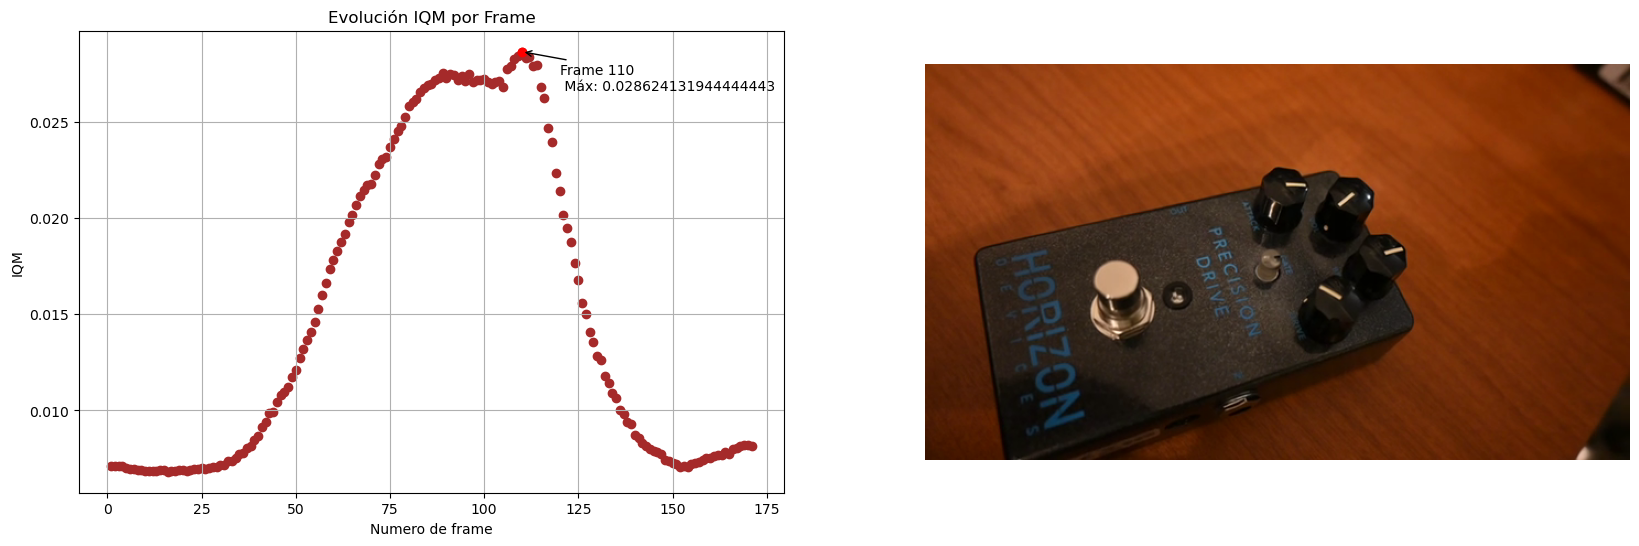

In [102]:
iqm_full_frame_list = procesar_video_completo(video_player, metric=calcular_iqm, name_metric='IQM')

#### 2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.

In [104]:
def procesar_video_roi(video_player, metric=calcular_iqm, name_metric='IQM', roi_number=0.05):
    video_player.restart()
    metric_lista = []

    video_player.set_roi(roi=roi_number)
    while True:
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salir del bucle        
        # Calcular IQM
        metric_lista.append(metric(video_player.get_roi_frame()))
    video_player.unset_roi()
    max_metric_frame = metric_lista.index(max(metric_lista)) + 1
    
    max_frame = video_player.get_frame_by_index(max_metric_frame)

    print(f'Frame de máximo {name_metric} {max_metric_frame} ({max(metric_lista)}')
    frame_indices = list(range(1, video_player.frame_count + 1))

    # Graficar los resultados
    graficar_con_frame(frame_indices, metric_lista, y_label=name_metric, frame_image=cv2.cvtColor(max_frame, cv2.COLOR_BGR2RGB))
    return metric_lista

Frame de máximo IQM ROI 5 % 96 (0.9409722222222222


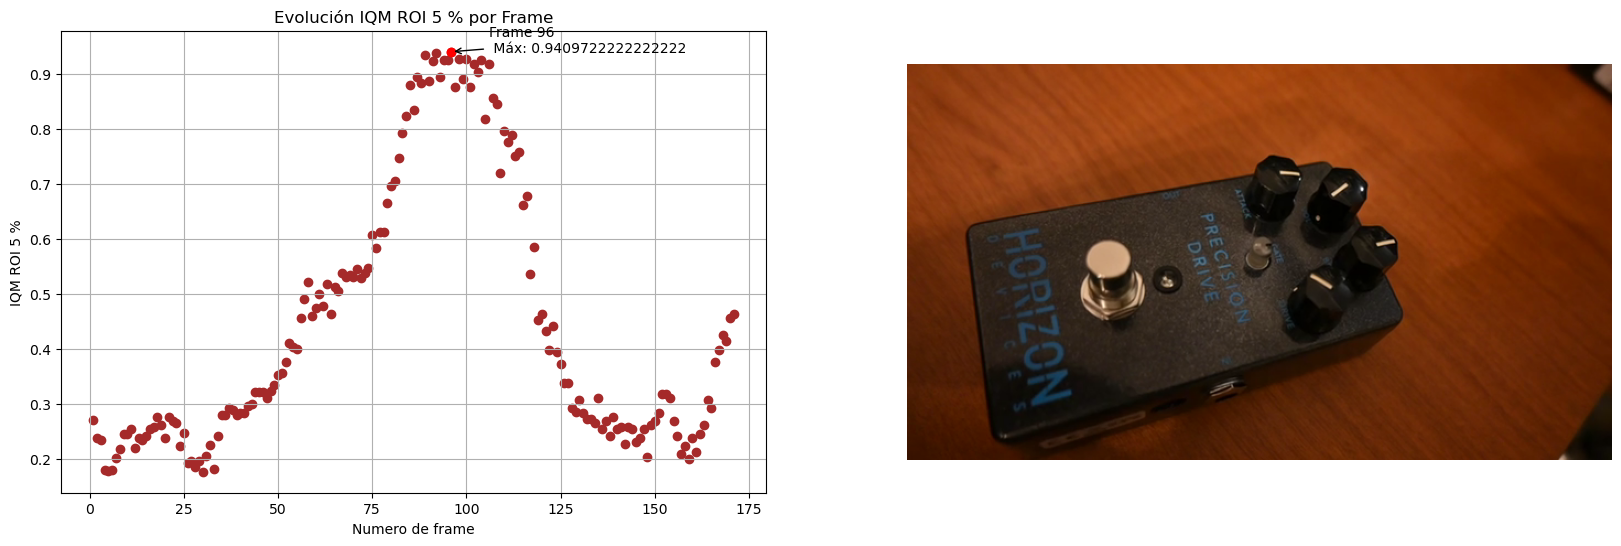

Frame de máximo IQM ROI 10 % 92 (0.7387152777777778


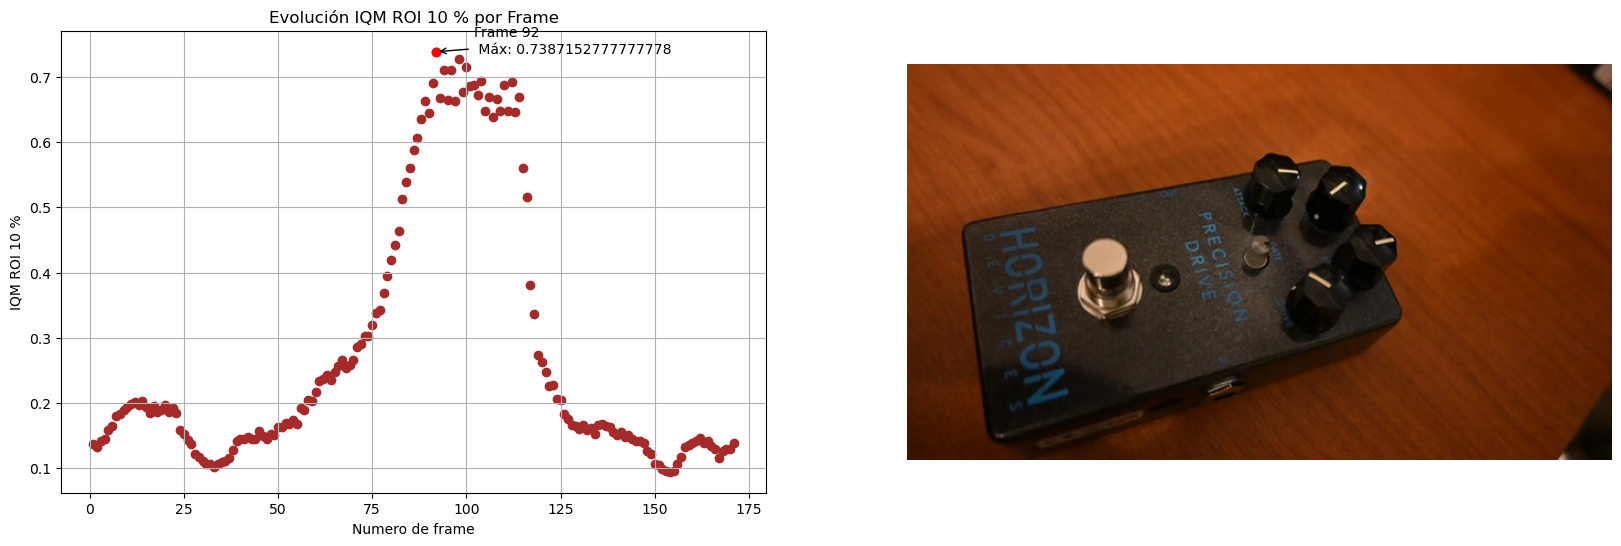

In [105]:
iqm_5_roi_frame_list = procesar_video_roi(video_player, metric=calcular_iqm, name_metric='IQM ROI 5 %', roi_number=0.05)
iqm_10_roi_frame_list = procesar_video_roi(video_player, metric=calcular_iqm, name_metric='IQM ROI 10 %',
                                           roi_number=0.1)

#### 3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

In [123]:
def procesar_video_roi_matrix(video_player, metric=calcular_iqm, name_metric='IQM', roi_number=0.05):
    video_player.unset_roi()
    video_player.restart()
    metric_lista = []

    video_player.set_roi(width=150, height=150, matrix=True, ncols=7, nrows=7)
    while True:
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salir del bucle        
        # Calcular IQM
        metric_lista.append(metric(video_player.get_roi_frame()))
    max_metric_frame = metric_lista.index(max(metric_lista)) + 1
    
    max_frame = video_player.get_frame_by_index(max_metric_frame)

    print(f'Frame de máximo {name_metric} {max_metric_frame} ({max(metric_lista)}')
    frame_indices = list(range(1, video_player.frame_count + 1))

    # Graficar los resultados
    graficar_con_frame(frame_indices, metric_lista, y_label=name_metric, frame_image=cv2.cvtColor(max_frame, cv2.COLOR_BGR2RGB))
    return metric_lista

Frame de máximo IQM ROI 40 % 112 (0.3506222222222222


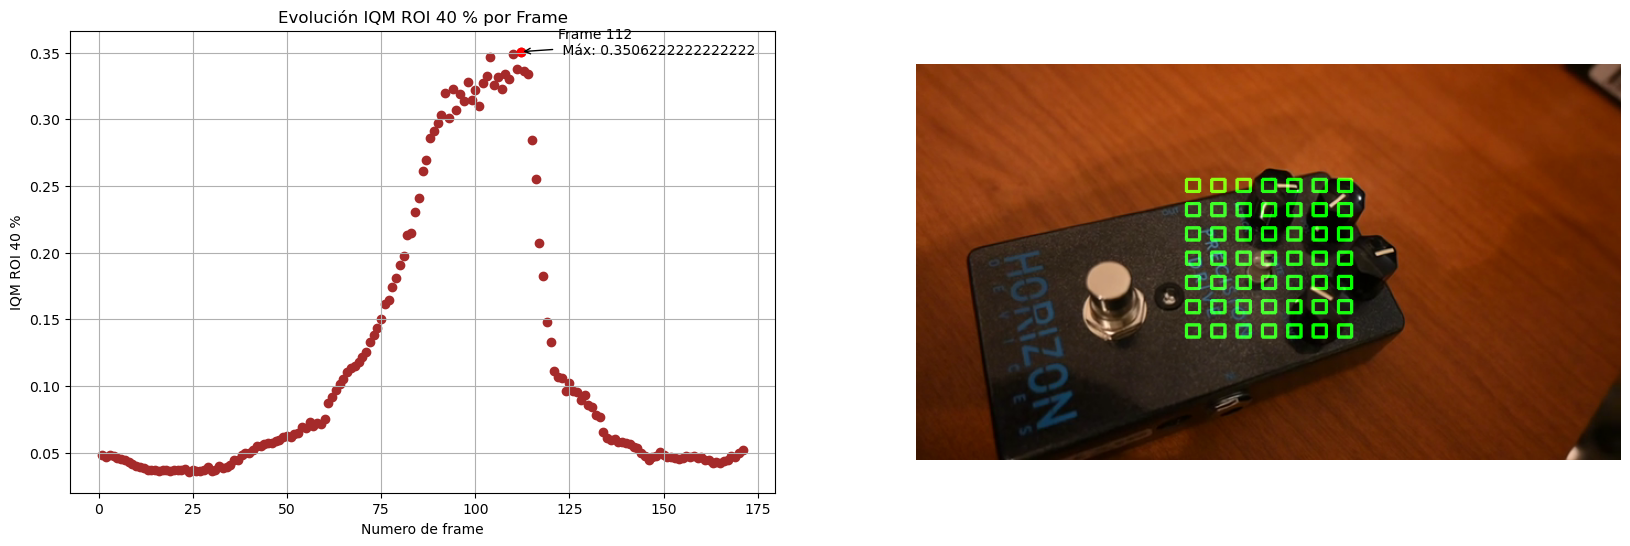

In [124]:
iqm_roi_matrix_3x3_frame_list = procesar_video_roi_matrix(video_player, metric=calcular_iqm, name_metric='IQM ROI 40 %',
                                           roi_number=0.35)

    EXPERIMENTO 1

In [13]:
matplotlib.use('Agg')
# Abre el video

video_player.restart()
video_player.set_roi(roi=0.2, matrix=True, nrows=5, ncols=5)

fm_score_list = list()

delay = int(600 / video_player.fps)

while True:
    frame = video_player.get_frame()
    if frame is None:
        break

    # Obtenemos la medicion    
    fm_score_list.append(calcular_iqm(video_player.get_roi_frame()))

    # Combina el frame original y la gráfica de la medicion del blur
    img_frame = convert_to_img(fm_score_list, video_player.shape, video_player.frame_count)
    frame_combined = np.hstack((frame, img_frame))
    # Mostrar el frame combinado
    cv2.imshow('Video', frame_combined)

    # Salir del loop si se presiona la tecla 'q'
    if cv2.waitKey(delay) & 0xFF == ord('q'):
        break

# Libera el objeto de captura de video y cierra todas las ventanas
cv2.waitKey(0)
cv2.destroyAllWindows()
%matplotlib inline

In [14]:
video_player.get_video_pos()

171.0

In [16]:
def procesar_video_completo(video_player, metric=calcular_iqm, name_metric='IQM'):
    video_player.restart()
    metric_lista = []
    frame_numeros = []

    while True:
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salir del bucle        
        # Calcular IQM
        metric_lista.append(metric(video_player.get_roi_frame()))

    max_metric_frame = metric_lista.index(max(metric_lista)) + 1

    print(f'Frame de máximo {name_metric} {max_metric_frame} ({max(metric_lista)}')
    frame_indices = list(range(1, video_player.frame_count + 1))

    # Graficar los resultados
    graficar(frame_indices, metric_lista, y_label=name_metric)

Frame de máximo IQM 110 (0.4935980902777778


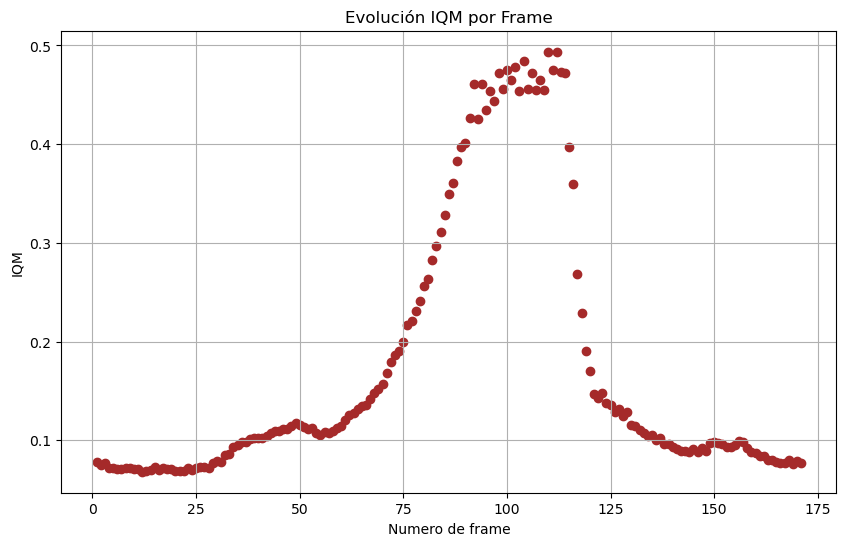

Frame de máximo ACM 113 (19.469030097678857


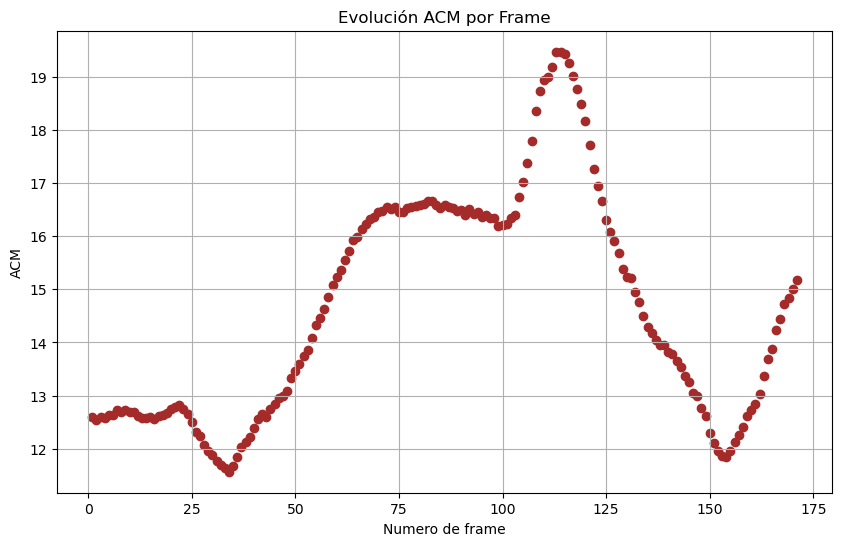

In [17]:
procesar_video_completo(video_player, metric=calcular_iqm, name_metric='IQM')
procesar_video_completo(video_player, metric=calcular_acm, name_metric='ACM')

Frame de maximo IQM 110 (0.028624131944444443)


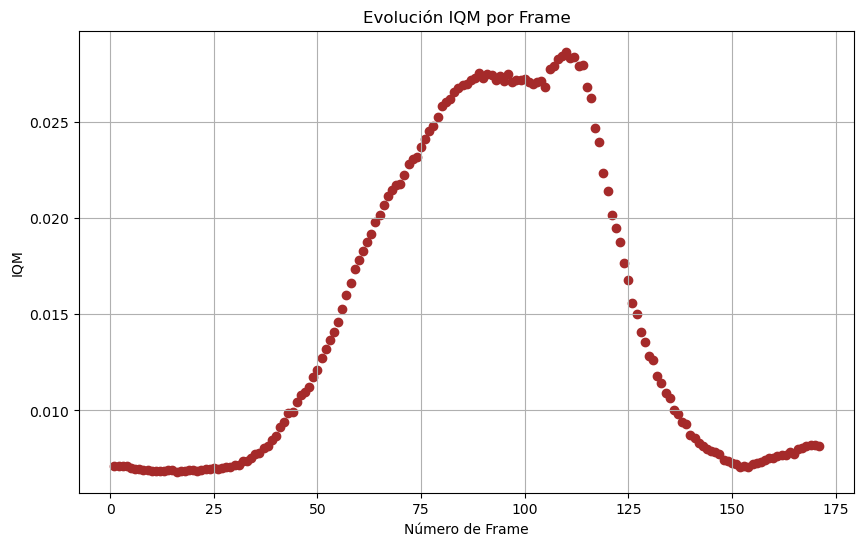

Frame de maximo ACM 118 (21.047174239321112)


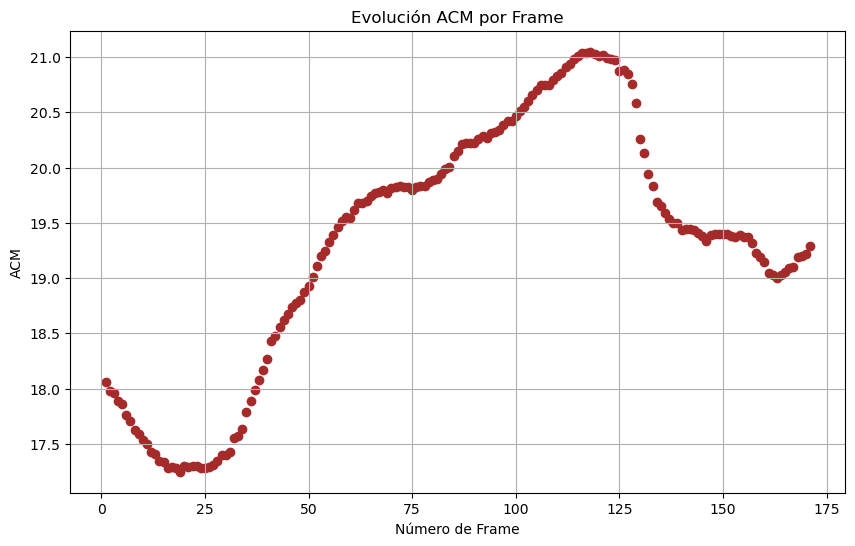

In [18]:
def procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM'):
    captura_video = cv2.VideoCapture(video_path)
    iqm_lista = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calcular IQM
        iqm = metric(frame_gris)
        iqm_lista.append(iqm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if iqm >= max(iqm_lista):
            max_iqm_frame = int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

    print(f'Frame de maximo {name_metric} {max_iqm_frame} ({max(iqm_lista)})')
    captura_video.release()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, iqm_lista, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric}')
    plt.title(f'Evolución {name_metric} por Frame')
    plt.grid(True)
    plt.show()


procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM')
procesar_video_completo(video_path, metric=calcular_acm, name_metric='ACM')

Frame de maximo IQM 110 (0.028624131944444443)


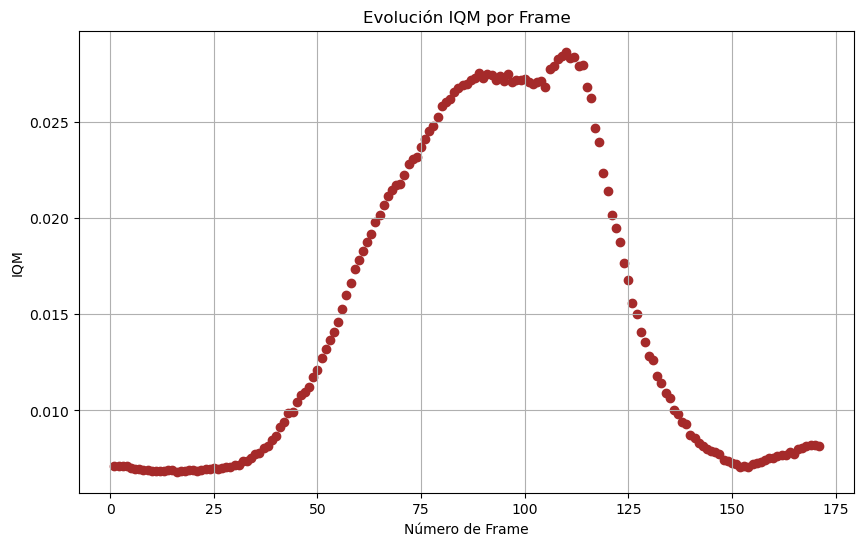

Frame de maximo ACM 118 (21.047174239321112)


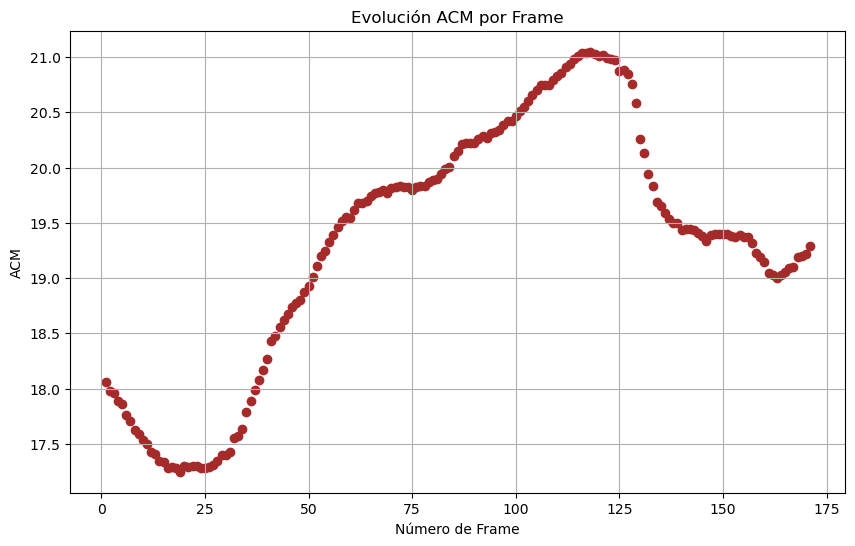

In [14]:
def procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM'):
    captura_video = cv2.VideoCapture(video_path)
    iqm_lista = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calcular IQM
        iqm = metric(frame_gris)
        iqm_lista.append(iqm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if iqm >= max(iqm_lista):
            max_iqm_frame = int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

    print(f'Frame de maximo {name_metric} {max_iqm_frame} ({max(iqm_lista)})')
    captura_video.release()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, iqm_lista, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric}')
    plt.title(f'Evolución {name_metric} por Frame')
    plt.grid(True)
    plt.show()


procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM')
procesar_video_completo(video_path, metric=calcular_acm, name_metric='ACM')

EXPERIMENTO 2

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 7.87 μs
Frame de máximo IQM 112 (0.4635339330945934


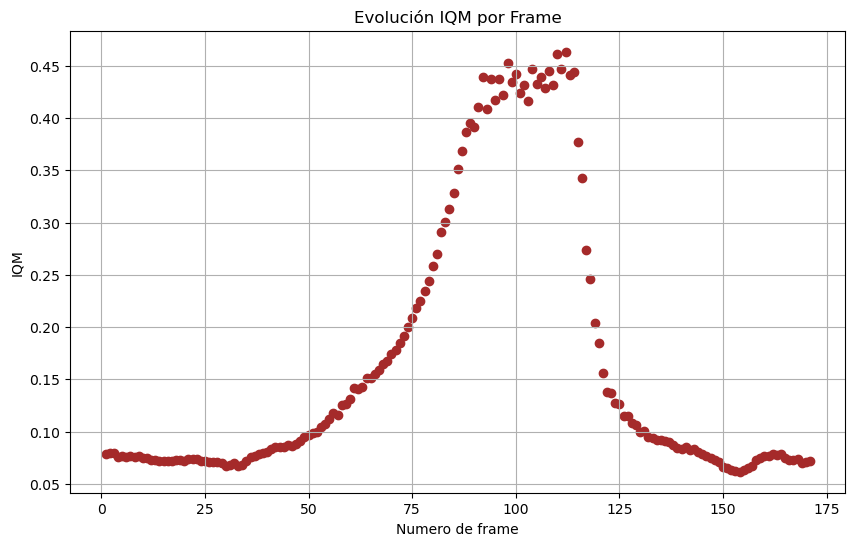

In [75]:
%time
video_player.set_roi(height=107, width=107)
procesar_video_completo(video_player, metric=calcular_iqm, name_metric='IQM')
# procesar_video_completo(video_player,metric=calcular_acm, name_metric = 'ACM')
video_player.unset_roi()

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.2 μs
Frame de maximo IQM 112 (0.4635339330945934)


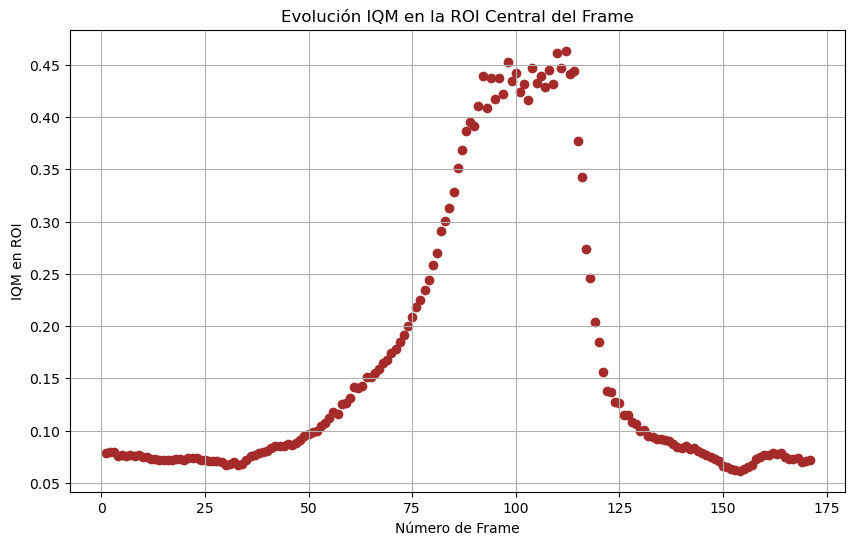

In [76]:
%time

def procesar_video_roi(video_path, porc_roi=0.05, metric=calcular_iqm, name_metric='IQM'):
    captura_video = cv2.VideoCapture(video_path)
    metric_list = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    # Primer bucle para calcular los IQM y el máximo IQM
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        # Obtener dimensiones del frame  
        height, width = frame.shape[:2]

        # Calcular el área total del frame  
        area_total = height * width

        # Calcular el área de la ROI en base al porcentaje  
        area_roi = area_total * porc_roi

        # Determinar la longitud y ancho de la ROI  
        roi_side = int((area_roi) ** 0.5)  # Lado de la ROI cuadrada (para simplicidad)  

        # Asegurarse de que la ROI no exceda los límites del frame  
        roi_side = min(roi_side, height, width)
        # Calcular las coordenadas de la ROI centrada  
        start_x = (width - roi_side) // 2
        start_y = (height - roi_side) // 2

        # Definir la ROI  
        roi = frame[start_y:start_y + roi_side, start_x:start_x + roi_side]

        # Convertir la ROI a escala de grises
        roi_gris = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        # Calcular IQM para la ROI
        value_metric = metric(roi_gris)
        metric_list.append(value_metric)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if value_metric >= max(metric_list):
            max_metric_frame = int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

    print(f'Frame de maximo {name_metric} {max_metric_frame} ({max(metric_list)})')

    # Capturamos el video de entrada  
    captura_video = cv2.VideoCapture(video_path)

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():
        print("Error al abrir el video.")
        exit()

    frame_number = 0
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        frame_number += 1

        # Verificamos si el número de frames coincide con el fotograma de la métrica máxima  
        if frame_number == max_metric_frame:
            cv2.rectangle(frame, (start_x, start_y), (start_x + roi_side, start_y + roi_side), (0, 255, 0),
                          2)  # Marco con verde el frame con métrica máxima  
        else:
            cv2.rectangle(frame, (start_x, start_y), (start_x + roi_side, start_y + roi_side), (0, 0, 255),
                          2)  # Marco con rojo el resto de los frames  

        # Mostrar el fotograma en una ventana  
        cv2.imshow('Video con ROI', frame)

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break
            # Liberar recursos  
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, metric_list, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric} en ROI')
    plt.title(f'Evolución {name_metric} en la ROI Central del Frame')
    plt.grid(True)
    plt.show()


procesar_video_roi(video_path, porc_roi=0.05, metric=calcular_iqm, name_metric='IQM')
#procesar_video_roi(video_path, porc_roi=0.05,metric = calcular_acm, name_metric = 'ACM')

EXPERIMENTO 3

Frame de maximo IQM 114 (0.9866666666666668)


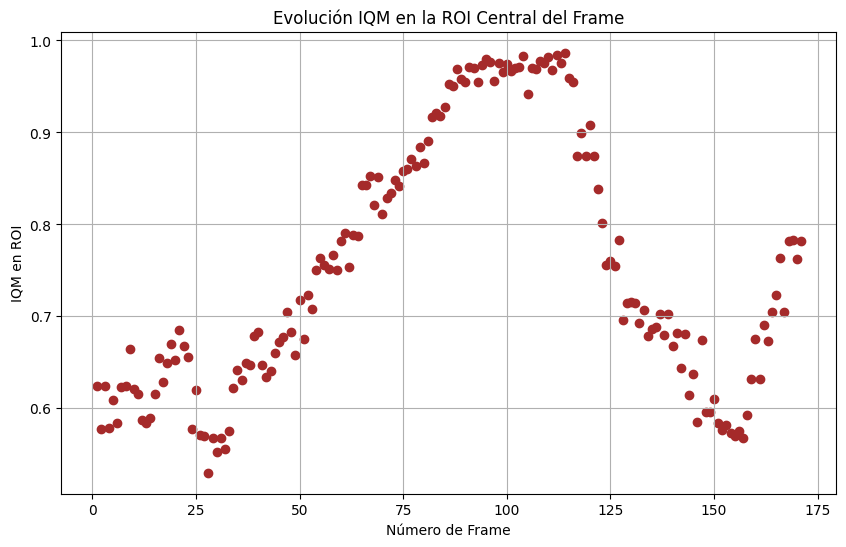

In [37]:
def procesar_video_focus_matrix(video_path, margin=10, range_X=3, range_Y=3, metric=calcular_iqm, name_metric='IQM'):
    captura_video = cv2.VideoCapture(video_path)

    metric_frame = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    # Primer bucle para calcular los IQM y el máximo IQM
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        height, width = frame.shape[:2]

        total_width = range_X * margin + (range_X - 1) * margin
        total_height = range_Y * margin + (range_Y - 1) * margin

        if total_width > width or total_height > height:
            print("El margen es demasiado grande para el tamaño del frame.")
            return [], frame  # Devolver la imagen sin modificaciones  

        start_x = (width - total_width) // 2
        start_y = (height - total_height) // 2

        rois = []  # Lista para almacenar los ROIs  

        for i in range(range_Y):
            for j in range(range_X):
                start_point = (start_x + j * (margin * 2),
                               start_y + i * (margin * 2))

                end_point = (start_point[0] + margin,
                             start_point[1] + margin)

                roi = frame[start_point[1]:end_point[1], start_point[0]:end_point[0]]
                rois.append((roi, (start_point, end_point)))

                # Convertir la ROI a escala de grises
        roi_gris = [cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) for roi, _ in rois]
        value_metric = [metric(roi).item() for roi in roi_gris]
        mean_metric = np.mean(value_metric).item()

        metric_frame.append(mean_metric)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))

    df_metric_values = pd.DataFrame({'frame': frame_numeros, 'metric': metric_frame})
    max_metric_frame = df_metric_values[df_metric_values.metric == df_metric_values.metric.max().item()]['frame'].item()
    max_metric_value = df_metric_values[df_metric_values.metric == df_metric_values.metric.max().item()][
        'metric'].item()

    print(f'Frame de maximo {name_metric} {max_metric_frame} ({max_metric_value})')

    # Capturamos el video de entrada  
    captura_video = cv2.VideoCapture(video_path)

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():
        print("Error al abrir el video.")
        exit()

    frame_number = 0
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        frame_number += 1

        for roi, (start_point, end_point) in rois:
            if frame_number == max_metric_frame:
                cv2.rectangle(frame, start_point, end_point, (0, 255, 0), 2)
            else:
                cv2.rectangle(frame, start_point, end_point, (0, 0, 255), 2)

                # Mostrar el fotograma en una ventana  
        cv2.imshow('Video con ROI', frame)

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break

            # Liberar recursos  
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, metric_frame, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric} en ROI')
    plt.title(f'Evolución {name_metric} en la ROI Central del Frame')
    plt.grid(True)
    plt.show()


procesar_video_focus_matrix(video_path, margin=10, range_X=3, range_Y=3, metric=calcular_iqm, name_metric='IQM')

Frame de maximo ACM 114 (9.364331428571429)


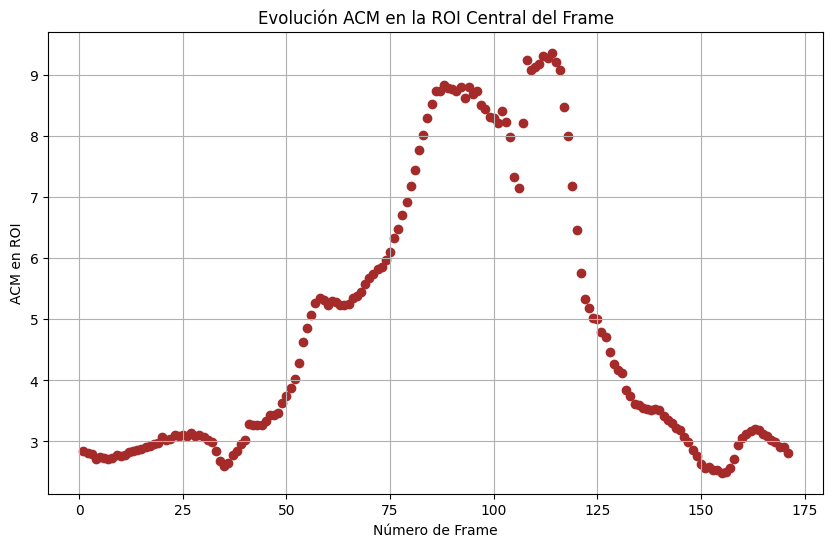

In [41]:
procesar_video_focus_matrix(video_path, margin=10, range_X=7, range_Y=5, metric=calcular_acm, name_metric='ACM')

### BONUS

UNSHARP MASKING --> algoritmo que tiende a enfocar o mejorar los bordes a traves de un filtro suavizado.
Pasos:
1. Aplicamos un filtro gaussiano para desenfocar
2. Restamos la imagen original con la suavizada para que sobrevivan los componentes de alta frecuencia
3. Agregamos la mascara a la imagen original.

In [25]:
def unsharp_masking(image, sigma=1.0, k=1.5):
    # Aplicar un filtro Gaussiano para obtener la imagen desenfocada
    gauss = cv2.GaussianBlur(image, (0, 0), sigma)

    # Calcular la imagen de la máscara de enfoque (imagen original - imagen desenfocada)
    sharpened = cv2.addWeighted(image, k + 1.0, gauss, -k, 0)

    # Asegurarse de que los valores estén en el rango de 0 a 255
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    return sharpened


In [30]:
def procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=False, sigma_um=1.0,
                            k_um=1.5):
    captura_video = cv2.VideoCapture(video_path)
    iqm_lista = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        if activate_um == True:
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_gris = unsharp_masking(frame_gris, sigma=sigma_um, k=k_um)
        else:
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calcular IQM
        iqm = metric(frame_gris)
        iqm_lista.append(iqm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if iqm >= max(iqm_lista):
            max_iqm_frame = int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

    print(f'Frame de maximo {name_metric} {max_iqm_frame} ({max(iqm_lista)})')
    captura_video.release()

    # Capturamos el video de entrada  
    captura_video = cv2.VideoCapture(video_path)

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():
        print("Error al abrir el video.")
        exit()

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        if activate_um == True:
            frame_um = unsharp_masking(frame, sigma=sigma_um, k=k_um)
        else:
            frame_um = frame

        # Mostrar el fotograma en una ventana  
        cv2.imshow('Video', frame_um)

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break
            # Liberar recursos  
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, iqm_lista, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric}')
    plt.title(f'Evolución {name_metric} por Frame')
    plt.grid(True)
    plt.show()

Frame de maximo IQM 110 (0.027842881944444446)


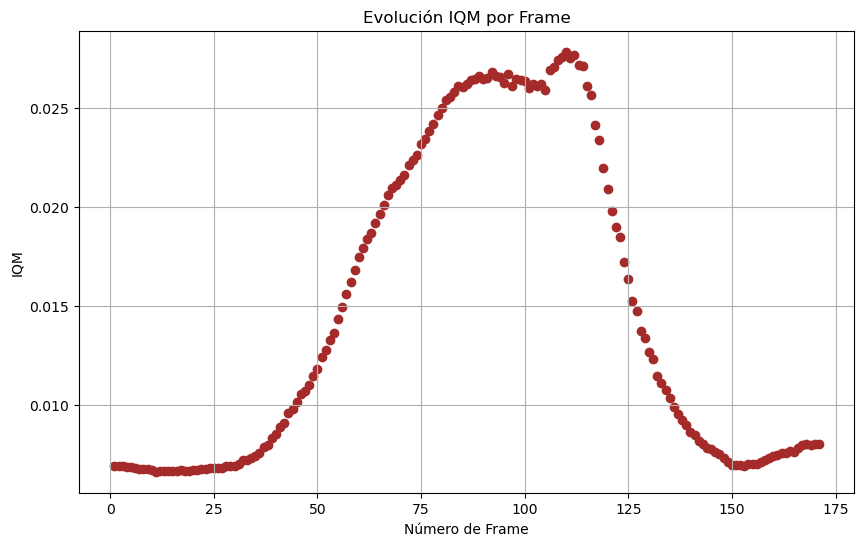

In [28]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=False, sigma_um=1.0, k_um=1)

Frame de maximo IQM 112 (0.0401171875)


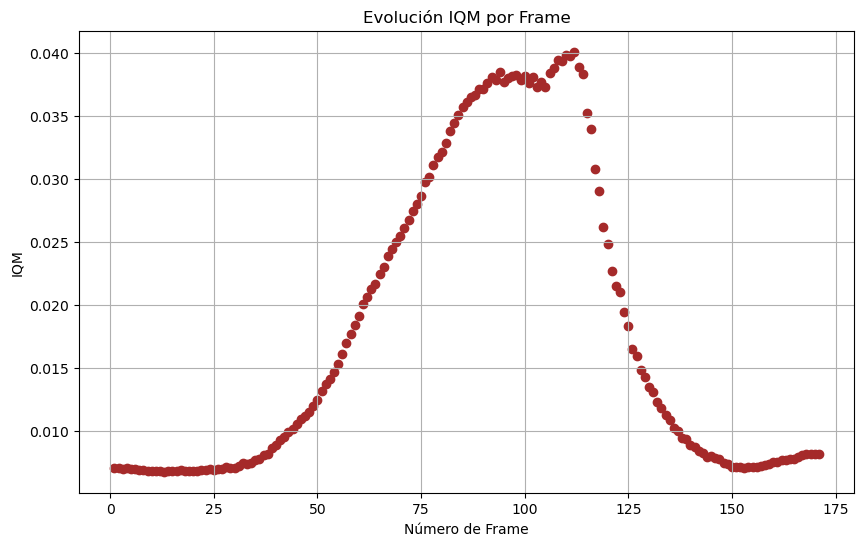

In [31]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=True, sigma_um=1.0, k_um=1)

Frame de maximo IQM 92 (0.3606727430555556)


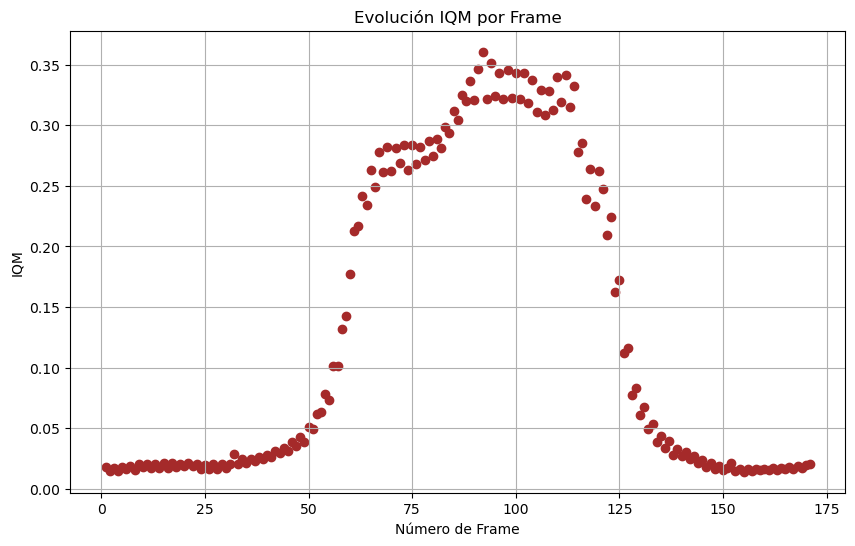

In [32]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=True, sigma_um=1.0, k_um=20)

APLICANDO EN UNSHARP MASKING SOLO A LOS FRAMES QUE ESTAN ENTRE EL P40 Y P60 DE LA DISTRIBUCION --> aqui lo que sucede es que cuando ponemos un K muy grande, terminamos rompiendo la distribución del IQM

In [33]:
def procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=False, sigma_um=1.0,
                            k_um=1.5, p_min=40, p_max=60):
    captura_video = cv2.VideoCapture(video_path)
    iqm_lista = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    # Primera pasada para calcular los IQM
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calcular IQM
        iqm = metric(frame_gris)
        iqm_lista.append(iqm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))

    captura_video.release()

    # Calcular los percentiles
    iqm_array = np.array(iqm_lista)
    p25, p75 = np.percentile(iqm_array, p_min), np.percentile(iqm_array, p_max)

    # Volver a capturar el video
    captura_video = cv2.VideoCapture(video_path)

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():
        print("Error al abrir el video.")
        exit()

    max_iqm_frame = -1
    max_iqm_value = -1
    iqm_final_lista = []  # Lista para IQM combinada

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        iqm = metric(frame_gris)

        # Aplicar unsharp masking solo si IQM está entre los percentiles definidos
        if activate_um and (p25 <= iqm <= p75):
            frame_um = unsharp_masking(frame, sigma=sigma_um, k=k_um)
        else:
            frame_um = frame

        # Calcular IQM para el frame procesado (ya sea con o sin unsharp masking)
        iqm_final = metric(cv2.cvtColor(frame_um, cv2.COLOR_BGR2GRAY))
        iqm_final_lista.append(iqm_final)

        # Mostrar el fotograma en una ventana  
        cv2.imshow('Video', frame_um)

        # Actualizar el frame de máximo IQM
        if iqm_final > max_iqm_value:
            max_iqm_value = iqm_final
            max_iqm_frame = int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break

            # Liberar recursos  
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, iqm_final_lista, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric} Final')
    plt.title(f'Evolución {name_metric} por Frame')
    plt.grid(True)
    plt.show()

    print(f'Frame de máximo {name_metric}: {max_iqm_frame} ({max_iqm_value})')

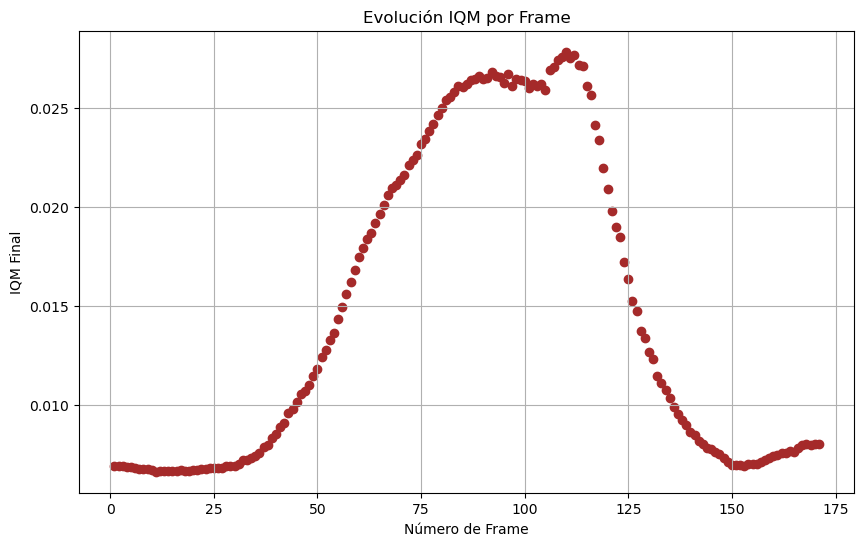

Frame de máximo IQM: 110 (0.027842881944444446)


In [34]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=False, sigma_um=1.0, k_um=1,
                        p_min=25, p_max=75)

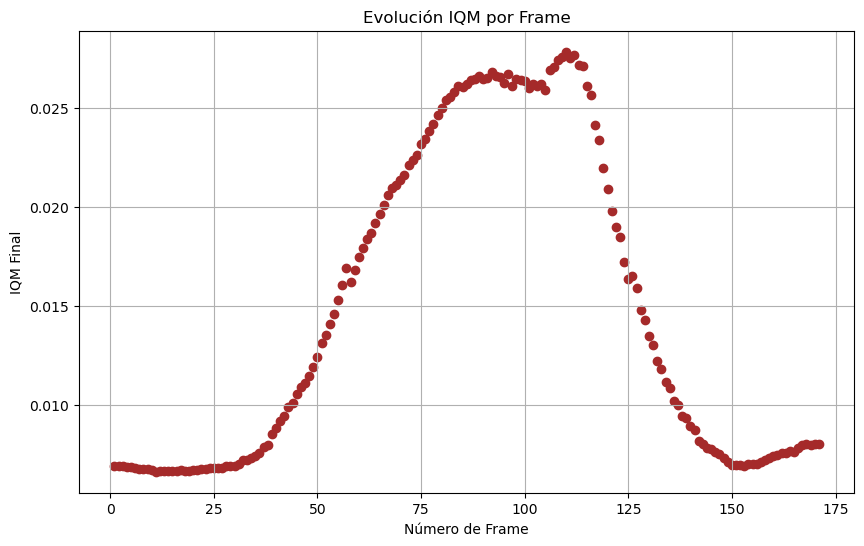

Frame de máximo IQM: 110 (0.027842881944444446)


In [35]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=True, sigma_um=1.0, k_um=1,
                        p_min=40, p_max=60)

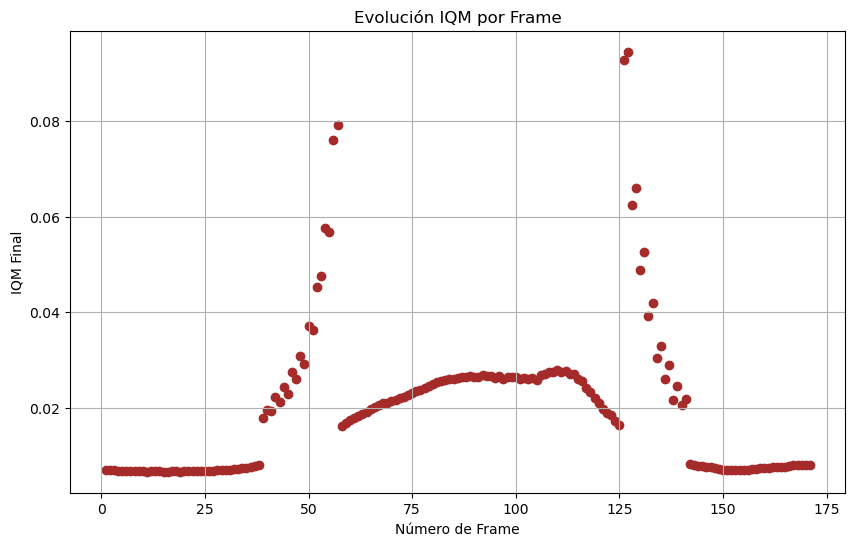

Frame de máximo IQM: 127 (0.09447916666666667)


In [36]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=True, sigma_um=1.0, k_um=20,
                        p_min=40, p_max=60)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [83]:
import http.client

conn = http.client.HTTPSConnection("postal-ninja.p.rapidapi.com")

payload = "-----011000010111000001101001\r\nContent-Disposition: form-data; name=\"to\"\r\n\r\nARCHIVED\r\n-----011000010111000001101001--\r\n\r\n"

headers = {
    'x-rapidapi-key': "24c797483bmsh4a688a5253198b3p1603ddjsnf346684fd319",
    'x-rapidapi-host': "postal-ninja.p.rapidapi.com",
    'Content-Type': "multipart/form-data; boundary=---011000010111000001101001",
    'Accept': "application/json; charset=UTF-8"
}

conn.request("POST", "/v1/track/CM124587725AR/move", payload, headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

400 Bad Request (Can't transform call to resource @86pclp356)
